# Health Insurance Risk Assessment & Cost Prediction

### Obtained data from National Health and Nutrition Examination Year 2013 
https://www.kaggle.com/cdc/national-health-and-nutrition-examination-survey 
#### Data Dictionary:
* **Demographic Dataset**: https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Demographics&CycleBeginYear=2013
* **Questionnaire dataset**: https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Questionnaire&CycleBeginYear=2013
 

## Import Libraries 

In [188]:
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import matplotlib
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import pickle

## Web Scrapping Data Dictionary

### Questionnaire file

In [189]:
web_page = requests.get("https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Questionnaire&CycleBeginYear=2013").text

soup = BeautifulSoup(web_page)

table_tags = soup.find("table", class_='table table-bordered table-striped')

tr_tags = table_tags.find_all("tr")

ques_dict_df = pd.DataFrame(columns=range(0,8), index = [0]) # I know the size

for row_marker, tr_tag in enumerate(tr_tags[1:]):
  column_marker = 0
  columns = tr_tag.find_all('td')
  for column in columns:
    ques_dict_df.loc[row_marker, column_marker] = column.get_text()
    column_marker += 1

headers = ['Variable Name', 'Variable Description', 'Data File Name', 'Data File Description', 'Begin Year', 'EndYear	', 'Component', 'Use Constraints']
ques_dict_df.columns = headers

#ques_dict_df.to_csv("questionnaire_data_dictionary.csv", index=False)

### Demographic File

In [190]:
web_page = requests.get("https://wwwn.cdc.gov/Nchs/Nhanes/Search/variablelist.aspx?Component=Demographics&CycleBeginYear=2013").text

soup = BeautifulSoup(web_page)

table_tags = soup.find("table", class_='table table-bordered table-striped')

tr_tags = table_tags.find_all("tr")

demo_dict_df = pd.DataFrame(columns=range(0,8), index = [0]) # I know the size

for row_marker, tr_tag in enumerate(tr_tags[1:]):
  column_marker = 0
  columns = tr_tag.find_all('td')
  for column in columns:
    demo_dict_df.loc[row_marker, column_marker] = column.get_text()
    column_marker += 1

headers = ['Variable Name', 'Variable Description', 'Data File Name', 'Data File Description', 'Begin Year', 'EndYear', 'Component', 'Use Constraints']
demo_dict_df.columns = headers

#demo_dict_df.to_csv("demographics_data_dictionary.csv", index=False)

## Import Datasets

In [191]:
ques_df = pd.read_csv('questionnaire.csv')
ques_df

,SEQN,ACD011A,ACD011B,ACD011C,ACD040,ACD110,ALQ101,ALQ110,ALQ120Q,ALQ120U,...,WHD080U,WHD080L,WHD110,WHD120,WHD130,WHD140,WHQ150,WHQ030M,WHQ500,WHQ520
0,73557,1.0,NaN,NaN,NaN,NaN,1.0,NaN,1.0,3.0,...,NaN,40.0,270.0,200.0,69.0,270.0,62.0,NaN,NaN,NaN
1,73558,1.0,NaN,NaN,NaN,NaN,1.0,NaN,7.0,1.0,...,NaN,NaN,240.0,250.0,72.0,250.0,25.0,NaN,NaN,NaN
2,73559,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,...,NaN,NaN,180.0,190.0,70.0,228.0,35.0,NaN,NaN,NaN
3,73560,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,3.0,3.0
4,73561,1.0,NaN,NaN,NaN,NaN,1.0,NaN,0.0,NaN,...,NaN,NaN,150.0,135.0,67.0,170.0,60.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,83727,NaN,NaN,NaN,3.0,NaN,1.0,NaN,1.0,2.0,...,NaN,NaN,NaN,NaN,NaN,150.0,26.0,NaN,NaN,NaN
10171,83728,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10172,83729,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,155.0,135.0,NaN,195.0,42.0,NaN,NaN,NaN
10173,83730,NaN,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [192]:
demo_df = pd.read_csv('demographic.csv')
demo_df

,SEQN,SDDSRVYR,RIDSTATR,RIAGENDR,RIDAGEYR,RIDAGEMN,RIDRETH1,RIDRETH3,RIDEXMON,RIDEXAGM,...,DMDHREDU,DMDHRMAR,DMDHSEDU,WTINT2YR,WTMEC2YR,SDMVPSU,SDMVSTRA,INDHHIN2,INDFMIN2,INDFMPIR
0,73557,8,2,1,69,NaN,4,4,1.0,NaN,...,3.0,4.0,NaN,13281.237386,13481.042095,1,112,4.0,4.0,0.84
1,73558,8,2,1,54,NaN,3,3,1.0,NaN,...,3.0,1.0,1.0,23682.057386,24471.769625,1,108,7.0,7.0,1.78
2,73559,8,2,1,72,NaN,3,3,2.0,NaN,...,4.0,1.0,3.0,57214.803319,57193.285376,1,109,10.0,10.0,4.51
3,73560,8,2,1,9,NaN,3,3,1.0,119.0,...,3.0,1.0,4.0,55201.178592,55766.512438,2,109,9.0,9.0,2.52
4,73561,8,2,2,73,NaN,3,3,1.0,NaN,...,5.0,1.0,5.0,63709.667069,65541.871229,2,116,15.0,15.0,5.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10170,83727,8,2,1,26,NaN,2,2,2.0,NaN,...,3.0,NaN,NaN,27141.631824,28115.568221,1,104,77.0,77.0,NaN
10171,83728,8,2,2,2,24.0,1,1,2.0,24.0,...,3.0,1.0,3.0,15274.475360,16512.138781,1,107,8.0,8.0,1.95
10172,83729,8,2,2,42,NaN,4,4,2.0,NaN,...,5.0,3.0,NaN,24122.248900,26902.344381,1,104,7.0,7.0,3.66
10173,83730,8,2,1,7,NaN,2,2,1.0,84.0,...,4.0,1.0,3.0,25521.878546,26686.025573,2,109,6.0,6.0,1.05


In [193]:
demo_dict_df = pd.read_csv('demographics_data_dictionary.csv')
demo_dict_df

,Variable Name,Variable Description,Data File Name,Data File Description,Begin Year,EndYear\t,Component,Use Constraints
0,AIALANGA,Language of the MEC ACASI Interview Instrument,DEMO_H,Demographic Variables and Sample Weights,2013,2014,Demographics,None
1,DMDBORN4,In what country {were you/was SP} born?,DEMO_H,Demographic Variables and Sample Weights,2013,2014,Demographics,None
2,DMDCITZN,{Are you/Is SP} a citizen of the United States...,DEMO_H,Demographic Variables and Sample Weights,2013,2014,Demographics,None
3,DMDEDUC2,What is the highest grade or level of school {...,DEMO_H,Demographic Variables and Sample Weights,2013,2014,Demographics,None
4,DMDEDUC3,What is the highest grade or level of school {...,DEMO_H,Demographic Variables and Sample Weights,2013,2014,Demographics,None
...,...,...,...,...,...,...,...,...
391,STM2KX,Census 2010 Geocoder Street Matcher Return Cod...,GEO_2010,"Geocoded Data, NHANES 1999-2016, Census 2010",1999,2016,Demographics,RDC Only
392,TRACT2KX,Census 2010 Tract (contains leader zeros with ...,GEO_2010,"Geocoded Data, NHANES 1999-2016, Census 2010",1999,2016,Demographics,RDC Only
393,TRACT2KX,Census 2010 Tract (contains leader zeros with ...,GEO_2010,"Geocoded Data, NHANES 1999-2016, Census 2010",1999,2016,Demographics,RDC Only
394,UR2KX,"Urban/Rural Indicator (U = Urban, R = Rural, b...",GEO_2010,"Geocoded Data, NHANES 1999-2016, Census 2010",1999,2016,Demographics,RDC Only


## Preprocessing 
1. *Renaming Demographic File*
2. *Questionnare Feature Selection*
2. *Questionnare Feature Generation*

## Renaming and Feature Selection :  Demographic File

In [194]:
demo_df.drop(columns=['RIDAGEMN','RIDEXMON','RIDEXAGM','DMQMILIZ','DMQADFC','DMDCITZN','DMDYRSUS','DMDEDUC3','DMDEDUC2','SIAPROXY','FIALANG',
                      'MIAPROXY','MIAINTRP','AIALANGA','DMDHRBR4','FIAPROXY','SIAINTRP','SIALANG','FIAINTRP','MIALANG'], inplace = True)

names = demo_dict_df['Variable Name']
keys = []
for name in names:
  if (name in demo_df.columns) and (name not in keys):
    keys.append(name)

des = ['Place Of Birth','No. of Family Members','No. of People in Household', 'No. of Children 5 or younger',
      'No. of Children aged 6-17', 'No. of adults aged 60+','HH Age','HH Education Level','HH Gender','HH Martial Status',
      'HH Spouse Education Level','Martial Status', 'Total Family Income','Family income: Poverty','Total household income',
       'Gender','Age','Pregnancy status','Race Recode','Race Recode','Interview and examination status','Data release cycle',
      'Masked variance unit pseudo-PSU','Masked variance unit pseudo-stratum','SEQN','2 year interview weight','2 year MEC exam weight']

col_dict = dict(zip(keys,des))

demo_df.rename(columns=col_dict,inplace=True)

demo_df.to_csv('demo_renamed.csv',index=False)

demo_df.drop(columns=['Data release cycle', 'Interview and examination status','Race Recode', 'Race Recode', 'Place Of Birth','2 year interview weight',
       '2 year MEC exam weight', 'Masked variance unit pseudo-PSU',
       'Masked variance unit pseudo-stratum'],axis=1,inplace = True)

#demo_df.to_csv('demo_dropped.csv',index=False)

## Renaming & Feature Selection: Questionnare File

This was done externally using excel  

## Feature Selection and Generation

Looking for chronic diseases that contribute to many health problems and are most common in egypt:
* **Diabetes**
* **Cholestrol**
* **Hypertension**
* **Stroke**
* **Heart Attack**

Habits that contribute to chronic diseases
* **Smoking**

*Liver conditions* and *obesity* are also common chronic diseases that are looked at but weren't available (most values were null)


### Values Definition
**1 = Yes**
**2 = No**
**3 = Don't Know**
**7 = Refused to answer**
**9 = Don't Know**

In [195]:
med_df = pd.DataFrame(columns=['SEQN','Heart Attack','Stroke'])

med_df['SEQN']=ques_df['SEQN']
med_df['Heart Attack'] = ques_df['MCQ160E']
med_df['Stroke'] = ques_df['MCQ160F']

# drop rows with 2 null values
med_df = med_df.dropna(thresh=med_df.shape[1]-1, axis=0)
med_df

,SEQN,Heart Attack,Stroke
0,73557,2.0,1.0
1,73558,2.0,2.0
2,73559,2.0,2.0
4,73561,2.0,2.0
5,73562,1.0,2.0
...,...,...,...
10166,83723,2.0,2.0
10167,83724,2.0,2.0
10169,83726,2.0,2.0
10170,83727,2.0,2.0


In [196]:
med_df.loc[med_df['Heart Attack'] == 9]

,SEQN,Heart Attack,Stroke
136,73693,9.0,9.0
6397,79954,9.0,2.0
8309,81866,9.0,2.0


In [197]:
med_df.loc[med_df['Heart Attack'] == 9,'Heart Attack'] = 2 # replace all don't knows with no

In [198]:
med_df.loc[med_df['Stroke'] == 9]

,SEQN,Heart Attack,Stroke
136,73693,2.0,9.0
528,74085,1.0,9.0
4587,78144,1.0,9.0
8238,81795,2.0,9.0
9818,83375,2.0,9.0


In [199]:
med_df.loc[med_df['Stroke'] == 9,'Stroke'] =2 # replace all don't knows with no

In [200]:
med_df.isnull().sum()

SEQN            0
Heart Attack    0
Stroke          0
dtype: int64

### Feature Generartion for Hypertension, Diabetes and Smoking

In [201]:
# create a dataframe to hold the chronic disease features
dihypsm_df = pd.DataFrame()
# fill with the corresponding data from the dictionary
dihypsm_df['SEQN'] = ques_df['SEQN']
dihypsm_df['Hypertension Age'] = ques_df['BPD035']
dihypsm_df['Hypertension atleast 1 time'] = ques_df['BPQ020']
dihypsm_df['Cholestrol'] = ques_df['BPQ080']
dihypsm_df['Diabetes Age'] = ques_df['DID040']
dihypsm_df['Family history of diabetes'] = ques_df['DIQ170']
dihypsm_df['Age Smoking'] = ques_df['SMD030']

In [202]:
# drop rows with 6 null values
dihypsm_df = dihypsm_df.dropna(thresh=dihypsm_df.shape[1]-5, axis=0)
dihypsm_df

,SEQN,Hypertension Age,Hypertension atleast 1 time,Cholestrol,Diabetes Age,Family history of diabetes,Age Smoking
0,73557,62.0,1.0,1.0,62.0,NaN,17.0
1,73558,53.0,1.0,1.0,23.0,NaN,0.0
2,73559,40.0,1.0,1.0,57.0,NaN,20.0
4,73561,55.0,1.0,2.0,NaN,2.0,NaN
5,73562,35.0,1.0,1.0,NaN,2.0,18.0
...,...,...,...,...,...,...,...
10166,83723,NaN,2.0,2.0,60.0,NaN,NaN
10167,83724,60.0,1.0,1.0,NaN,2.0,18.0
10169,83726,NaN,2.0,2.0,NaN,2.0,NaN
10170,83727,NaN,2.0,2.0,NaN,2.0,NaN


#### Diabetes Feature Generation

In [203]:
# All people that have answered the diabetes age question will be put in a diabetic dataframe
# All people that haven't answered the diabetes age question and don't have any family history for diabetes will be put in a non-diabetic datafram
# All people that haven't answered the diabetes age question and have family history for diabetes will be put in a prediabetic dataframe
dia_yes = dihypsm_df.loc[dihypsm_df['Diabetes Age'].isnull() == False]
dia_no = dihypsm_df.loc[(dihypsm_df['Diabetes Age'].isnull() == True) & (dihypsm_df['Family history of diabetes'] == 2)]
dia_maybe = dihypsm_df.loc[(dihypsm_df['Diabetes Age'].isnull() == True) & (dihypsm_df['Family history of diabetes'] == 1)]

In [ ]:
# each value contributes to yes, no, prediabetic
dia_yes['Diabetes'] = 1
dia_no['Diabetes'] = 2
dia_maybe['Diabetes'] = 0.5

In [ ]:
#drop diabetes age and family history of diabetes from dataframes
dihypsm_df.drop(columns=['Diabetes Age','Family history of diabetes'], inplace = True)
dia_yes.drop(columns=['Diabetes Age','Family history of diabetes'], inplace = True)
dia_no.drop(columns=['Diabetes Age','Family history of diabetes'], inplace = True)
dia_maybe.drop(columns=['Diabetes Age','Family history of diabetes'], inplace = True)

In [206]:
# merge all three diabetes categories
dia = dia_yes.append(dia_maybe, ignore_index=True)
dia = dia.append(dia_no, ignore_index=True)
dihypsm_df['Diabetes'] = dihypsm_df.SEQN.map(dia.set_index('SEQN')['Diabetes']).fillna(2) # fill the null values with 2
dihypsm_df

,SEQN,Hypertension Age,Hypertension atleast 1 time,Cholestrol,Age Smoking,Diabetes
0,73557,62.0,1.0,1.0,17.0,1.0
1,73558,53.0,1.0,1.0,0.0,1.0
2,73559,40.0,1.0,1.0,20.0,1.0
4,73561,55.0,1.0,2.0,NaN,2.0
5,73562,35.0,1.0,1.0,18.0,2.0
...,...,...,...,...,...,...
10166,83723,NaN,2.0,2.0,NaN,1.0
10167,83724,60.0,1.0,1.0,18.0,2.0
10169,83726,NaN,2.0,2.0,NaN,2.0
10170,83727,NaN,2.0,2.0,NaN,2.0


#### Hypertension Feature Generation


In [207]:
# replacing the hypertension age into a hypertension feature containing yes or no
# if someone answered the hypertension age then that person has hypertension 
dihypsm_df.loc[(dihypsm_df['Hypertension Age'].isna() == False), 'Hypertension Age'] = 1
# assume that if someone didn't answer the hypertension age but has been told that they has been told that they have hypertension one time or more
dihypsm_df.loc[(dihypsm_df['Hypertension Age'].isna() == True) & (dihypsm_df['Hypertension atleast 1 time'] == 1), 'Hypertension Age'] = 1
# assume that remaing null values in hypertension age mean that they don't have hypertension
dihypsm_df.loc[(dihypsm_df['Hypertension Age'].isna() == True), 'Hypertension Age'] = 2
# drop the hypertension atleast 1 time feature
dihypsm_df.drop(columns=['Hypertension atleast 1 time'], inplace = True)

#### Smoking Feature Generation

In [208]:
#if someone answered the smoking age question then assume as smoker
#if someone didn't answer the smoking age question assume as non-smoker
dihypsm_df.loc[(dihypsm_df['Age Smoking'].isna() == False), 'Age Smoking'] = 1
dihypsm_df.loc[(dihypsm_df['Age Smoking'].isna() == True), 'Age Smoking'] = 2

In [209]:
dihypsm_df.rename(columns={"Hypertension Age": 'Hypertension', "Age Smoking": 'Smoking'}, inplace = True)

#### Cholestrol Feature

In [210]:
dihypsm_df.loc[dihypsm_df['Cholestrol'].isna()] = 2 # assume that all nulls are no
dihypsm_df.loc[dihypsm_df['Cholestrol'] == 9 ,'Cholestrol'] = 2 # assume that all don't knows are no 

In [211]:
# merge the dihypsm dataframe to the inital med dataframe
med_df = med_df.merge(dihypsm_df, on='SEQN')
med_df

,SEQN,Heart Attack,Stroke,Hypertension,Cholestrol,Smoking,Diabetes
0,73557,2.0,1.0,1.0,1.0,1.0,1.0
1,73558,2.0,2.0,1.0,1.0,1.0,1.0
2,73559,2.0,2.0,1.0,1.0,1.0,1.0
3,73561,2.0,2.0,1.0,2.0,2.0,2.0
4,73562,1.0,2.0,1.0,1.0,1.0,2.0
...,...,...,...,...,...,...,...
5764,83723,2.0,2.0,2.0,2.0,2.0,1.0
5765,83724,2.0,2.0,1.0,1.0,1.0,2.0
5766,83726,2.0,2.0,2.0,2.0,2.0,2.0
5767,83727,2.0,2.0,2.0,2.0,2.0,2.0


## Reselecting Demographic Features

In [212]:
med_df['Gender'] = med_df.SEQN.map(demo_df.set_index('SEQN')['Gender']) # 1- MALE , 2- FEMALE
med_df['Age'] = med_df.SEQN.map(demo_df.set_index('SEQN')['Age'])
med_df['Pregnancy Status']=  med_df.SEQN.map(demo_df.set_index('SEQN')['Pregnancy status']) #1- YES, 2- NO, 3- DON'T KNOW

In [213]:
# let all male participents have a pregnancy status of 0 for unqualified
med_df.loc[med_df['Gender'] == 1, 'Pregnancy Status'] = 0
# assume that any female that didn't answer isn't pregnant
med_df.loc[(med_df['Gender'] == 2) & (med_df['Pregnancy Status'].isna() == True), 'Pregnancy Status'] = 2
# replace the don't knows with not pregnant
med_df.loc[med_df['Pregnancy Status']== 3, 'Pregnancy Status'] = 2
med_df

,SEQN,Heart Attack,Stroke,Hypertension,Cholestrol,Smoking,Diabetes,Gender,Age,Pregnancy Status
0,73557,2.0,1.0,1.0,1.0,1.0,1.0,1,69,0.0
1,73558,2.0,2.0,1.0,1.0,1.0,1.0,1,54,0.0
2,73559,2.0,2.0,1.0,1.0,1.0,1.0,1,72,0.0
3,73561,2.0,2.0,1.0,2.0,2.0,2.0,2,73,2.0
4,73562,1.0,2.0,1.0,1.0,1.0,2.0,1,56,0.0
...,...,...,...,...,...,...,...,...,...,...
5764,83723,2.0,2.0,2.0,2.0,2.0,1.0,1,61,0.0
5765,83724,2.0,2.0,1.0,1.0,1.0,2.0,1,80,0.0
5766,83726,2.0,2.0,2.0,2.0,2.0,2.0,1,40,0.0
5767,83727,2.0,2.0,2.0,2.0,2.0,2.0,1,26,0.0


In [214]:
med_df.set_index('SEQN',inplace=True)
#med_df.to_csv('Initial_Features_df.csv',index=True)

## Risk Assessment Clustering

After trying multiple clustering techniques 
* **DBSCAN**
* **Agglomerative Clustering**
* **KMeans** <br>

KMeans clustering showed the best efficiency

## Scaling Data

In [215]:
norm = MinMaxScaler().fit_transform(df)
df_norm = pd.DataFrame(norm, index=med_df.index,columns=med_df.columns)
df_norm

,Heart Attack,Stroke,Hypertension,Cholestrol,Smoking,Diabetes,Gender,Age,Pregnancy Status
SEQN,,,,,,,,,
73557,1.0,0.0,0.0,0.0,0.0,0.333333,0.0,0.816667,0.000000
73558,1.0,1.0,0.0,0.0,0.0,0.333333,0.0,0.566667,0.000000
73559,1.0,1.0,0.0,0.0,0.0,0.333333,0.0,0.866667,0.000000
73561,1.0,1.0,0.0,1.0,1.0,1.000000,1.0,0.883333,0.666667
73562,0.0,1.0,0.0,0.0,0.0,1.000000,0.0,0.600000,0.000000
...,...,...,...,...,...,...,...,...,...
83723,1.0,1.0,1.0,1.0,1.0,0.333333,0.0,0.683333,0.000000
83724,1.0,1.0,0.0,0.0,0.0,1.000000,0.0,1.000000,0.000000
83726,1.0,1.0,1.0,1.0,1.0,1.000000,0.0,0.333333,0.000000


In [216]:
# Drop gender before starting clustering
df_norm.drop(columns=['Gender'], inplace=True)

## Apply PCA for Dimentionality Reduction to increase efficiency 

In [217]:
pca = PCA(0.75)
pca.fit(df_norm)
pca_df = pca.transform(df_norm)
pca_df = pd.DataFrame(pca_df, index=df.index, columns=['PCA1','PCA2','PCA3','PCA4'])
pca_df

,PCA1,PCA2,PCA3,PCA4
SEQN,,,,
73557,1.204746,-0.323019,-0.064038,0.188303
73558,1.065007,-0.333416,-0.103710,0.203325
73559,1.155557,-0.321948,-0.095184,0.167345
73561,0.154829,0.502369,0.728467,-0.262050
73562,1.022197,-0.419865,-0.090318,-0.421713
...,...,...,...,...
83723,-0.412104,0.279486,-0.033730,0.336330
83724,1.063408,-0.390012,-0.090355,-0.460043
83726,-0.650141,0.192944,-0.042637,-0.233089


## Applying KMeans

In [218]:
# draw the elbow curve
def elbowcurve(df):
    SSE = []
    for i in range(2,20):
        x_clusters, sse = kmean(df,i)
        SSE.append(sse)
    plt.figure()
    plt.plot(SSE, 'ro:')
    plt.xlabel('K')
    plt.ylabel('SSE')
    plt.title('Elbow Curve', size=20)
    plt.show()

In [219]:
# apply kmeans and get sse
def kmean(df, clus):
    km = KMeans(n_clusters=clus, init='k-means++', random_state=0)
    km.fit(df)
    return km.predict(df), round(km.inertia_,2)

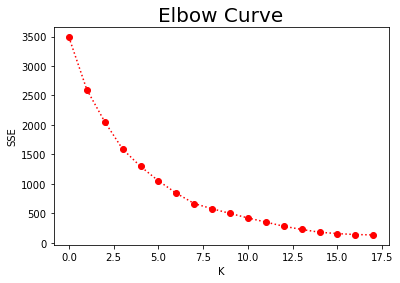

In [220]:
elbowcurve(pca_df) # from the elbow curve get the best k value

In [221]:
x_clusters,sse= kmean(pca_df,7)
print('SSE = ', sse)

SSE =  1050.83


## Create Clustered Dataframe

In [222]:
df_clustered = df.copy()
df_clustered['Cluster'] = x_clusters
df_clustered

,Heart Attack,Stroke,Hypertension,Cholestrol,Smoking,Diabetes,Gender,Age,Pregnancy Status,Cluster
SEQN,,,,,,,,,,
73557,2.0,1.0,1.0,1.0,1.0,1.0,1,69,0.0,1
73558,2.0,2.0,1.0,1.0,1.0,1.0,1,54,0.0,1
73559,2.0,2.0,1.0,1.0,1.0,1.0,1,72,0.0,1
73561,2.0,2.0,1.0,2.0,2.0,2.0,2,73,2.0,6
73562,1.0,2.0,1.0,1.0,1.0,2.0,1,56,0.0,1
...,...,...,...,...,...,...,...,...,...,...
83723,2.0,2.0,2.0,2.0,2.0,1.0,1,61,0.0,0
83724,2.0,2.0,1.0,1.0,1.0,2.0,1,80,0.0,1
83726,2.0,2.0,2.0,2.0,2.0,2.0,1,40,0.0,0


In [223]:
#df_clustered.to_csv('PCA_Clusterd_df.csv',index=False)

## Classifier

In [ ]:
# used logistic regressor as the classifier for classifying any input data into a cluster
X_train, X_test, y_train, y_test = train_test_split(df_clustered.drop(columns=['Cluster']), df_clustered.Cluster, test_size=0.3, random_state=0)
model = LogisticRegression(random_state=42)
model.fit(X_train, y_train)

In [227]:
# save the classifier model for later use
filename = 'cluster_model.sav'
#pickle.dump(model, open(filename, 'wb'))

# Cost Prediction Reggressor

Completed at different Notebook